In [ ]:
!pip install yfinance --quiet
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

try:
    from xgboost import XGBRegressor
    XGB_OK = True
except ImportError:
    XGB_OK = False

In [ ]:
ticker = "GC=F"
start_date = "2020-01-01"
end_date = "2025-12-31"

raw = yf.download(ticker, start=start_date, end=end_date, auto_adjust=True)
raw.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,GC=F,GC=F,GC=F,GC=F,GC=F
Date,,,,,
2020-01-02,1524.500000,1528.699951,1518.000000,1518.099976,214
2020-01-03,1549.199951,1552.699951,1530.099976,1530.099976,107
2020-01-06,1566.199951,1580.000000,1560.400024,1580.000000,416
2020-01-07,1571.800049,1576.300049,1558.300049,1558.300049,47
2020-01-08,1557.400024,1604.199951,1552.300049,1579.699951,236


In [ ]:
price_col = "Close" if "Adj Close" not in raw.columns else "Adj Close"

# Access the specific MultiIndex column using (level_0_name, level_1_name)
# Then resample and convert to a DataFrame with a single column named 'Price'
monthly = raw[(price_col, ticker)].resample("M").last().to_frame(name="Price")
monthly.index.name = "Date"
monthly = monthly.reset_index()

/tmp/ipython-input-1994950131.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = raw[(price_col, ticker)].resample("M").last().to_frame(name="Price")


In [ ]:
monthly.head(), monthly.tail(), monthly["Date"].min(), monthly["Date"].max(), len(monthly)

(        Date        Price
 0 2020-01-31  1582.900024
 1 2020-02-29  1564.099976
 2 2020-03-31  1583.400024
 3 2020-04-30  1684.199951
 4 2020-05-31  1736.900024,
          Date        Price
 66 2025-07-31  3293.199951
 67 2025-08-31  3473.699951
 68 2025-09-30  3840.800049
 69 2025-10-31  3982.199951
 70 2025-11-30  4009.800049,
 Timestamp('2020-01-31 00:00:00'),
 Timestamp('2025-11-30 00:00:00'),
 71)

In [ ]:
train = monthly[(monthly["Date"] >= "2020-01-01") & (monthly["Date"] <= "2024-12-31")].copy()
test = monthly[(monthly["Date"] >= "2025-01-01") & (monthly["Date"] <= "2025-12-31")].copy()

print(train["Date"].min(), train["Date"].max(), len(train))
print(test["Date"].min(), test["Date"].max(), len(test))

2020-01-31 00:00:00 2024-12-31 00:00:00 60
2025-01-31 00:00:00 2025-11-30 00:00:00 11


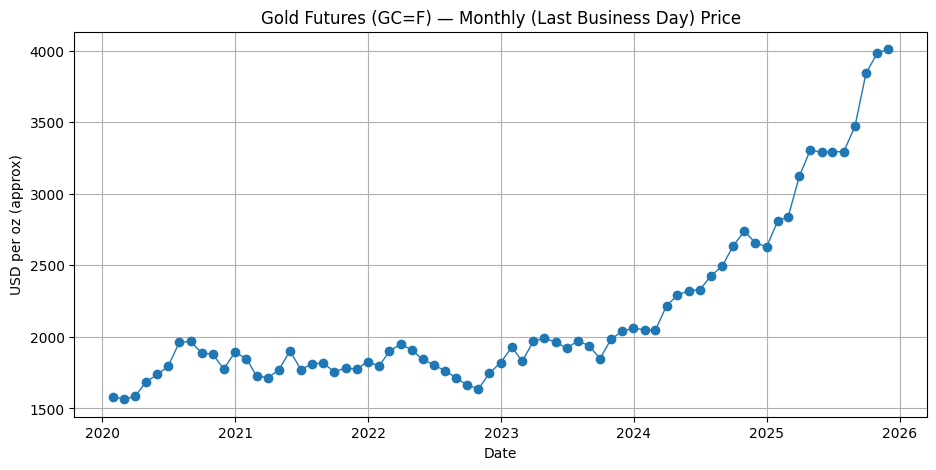

In [ ]:
plt.figure(figsize=(11,5))
plt.plot(monthly["Date"], monthly["Price"], marker="o", linewidth=1)
plt.title("Gold Futures (GC=F) — Monthly (Last Business Day) Price")
plt.xlabel("Date"); plt.ylabel("USD per oz (approx)")
plt.grid(True); plt.show()


In [ ]:
t0 = train["Date"].iloc[0]
train["t_days"] = (train["Date"] - t0).dt.days.astype(float)
t = train["t_days"].values
y = train["Price"].values
train[["Date","t_days","Price"]].head()


,Date,t_days,Price
0,2020-01-31,0.0,1582.900024
1,2020-02-29,29.0,1564.099976
2,2020-03-31,60.0,1583.400024
3,2020-04-30,90.0,1684.199951
4,2020-05-31,121.0,1736.900024


In [ ]:
t_bar = t.mean()
y_bar = y.mean()

alpha = ((t - t_bar) * (y - y_bar)).sum() / ((t - t_bar)**2).sum()
beta  = y_bar - alpha * t_bar

print(f"Trend slope (USD/day): {alpha:.6f}, intercept: {beta:.3f}")

Trend slope (USD/day): 0.395687, intercept: 1588.772


In [ ]:
omega = 2*np.pi/365.0

# Detrend
y_detr = y - (alpha*t + beta)

# Linear least squares for a*sin + b*cos
X = np.column_stack([np.sin(omega*t), np.cos(omega*t)])
a, b = np.linalg.lstsq(X, y_detr, rcond=None)[0]

amplitude = np.sqrt(a*a + b*b)
phase = np.arctan2(b, a)  # interpretable: y_seas ≈ A*sin(ωt + phase)
print(f"a={a:.6f}, b={b:.6f}, amplitude={amplitude:.3f}, phase(rad)={phase:.3f}")

a=-8.608182, b=-21.082727, amplitude=22.772, phase(rad)=-1.958


In [ ]:
def model_price_at_datetime(ts):
    ts = pd.to_datetime(ts)
    t_days = (ts - t0).days
    trend = alpha * t_days + beta
    seas  = a * np.sin(omega * t_days) + b * np.cos(omega * t_days)
    return float(trend + seas)

In [ ]:
train_fit = [model_price_at_datetime(d) for d in train["Date"]]
mae_train = np.mean(np.abs(train["Price"].values - np.array(train_fit)))
print(f"Train MAE (2020–2024): {mae_train:.2f} USD")

Train MAE (2020–2024): 136.43 USD


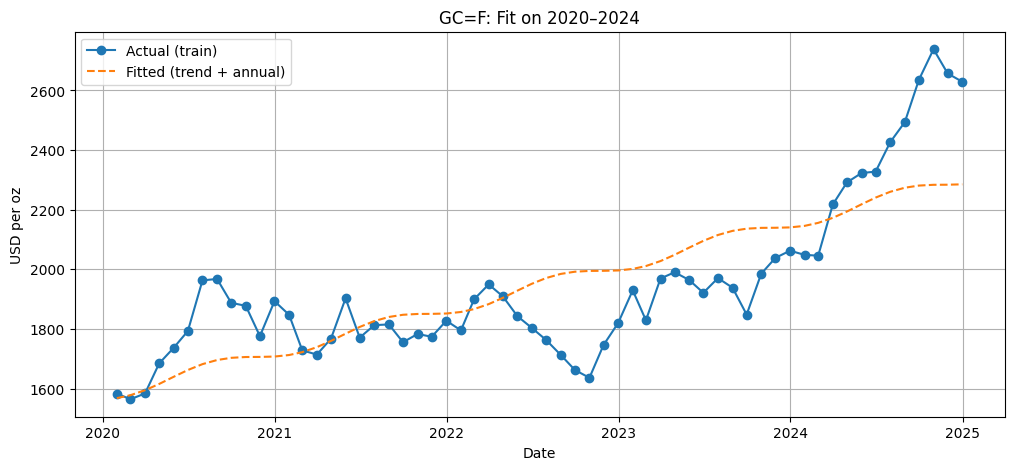

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(train["Date"], train["Price"], "o-", label="Actual (train)")
plt.plot(train["Date"], train_fit, "--", label="Fitted (trend + annual)")
plt.title("GC=F: Fit on 2020–2024")
plt.xlabel("Date"); plt.ylabel("USD per oz")
plt.grid(True); plt.legend(); plt.show()

In [ ]:
# Ensure test set has same t reference
test = test.copy()
test["t_days"] = (test["Date"] - t0).dt.days.astype(float)

test["Forecast"] = [model_price_at_datetime(d) for d in test["Date"]]
test.head(15)


,Date,Price,t_days,Forecast
60,2025-01-31,2812.500000,1827.0,2290.326367
61,2025-02-28,2836.800049,1855.0,2300.188327
62,2025-03-31,3122.800049,1886.0,2317.082301
63,2025-04-30,3305.000000,1916.0,2338.210247
64,2025-05-31,3288.899902,1947.0,2362.391259
65,2025-06-30,3294.399902,1977.0,2384.974263
66,2025-07-31,3293.199951,2008.0,2404.468351
67,2025-08-31,3473.699951,2039.0,2418.079411
68,2025-09-30,3840.800049,2069.0,2425.284189
69,2025-10-31,3982.199951,2100.0,2427.868121


In [ ]:
# Align on months available in 2025 data
valid = test.dropna(subset=["Price", "Forecast"]).copy()
valid["AbsErr"] = (valid["Price"] - valid["Forecast"]).abs()
valid["APE"]    = valid["AbsErr"] / valid["Price"] * 100

mae_2025  = valid["AbsErr"].mean()
mape_2025 = valid["APE"].mean()

print(f"2025 MAE:  {mae_2025:.2f} USD")
print(f"2025 MAPE: {mape_2025:.2f}%")

valid[["Date","Price","Forecast","AbsErr","APE"]]


2025 MAE:  1014.82 USD
2025 MAPE: 29.18%


,Date,Price,Forecast,AbsErr,APE
60,2025-01-31,2812.500000,2290.326367,522.173633,18.566174
61,2025-02-28,2836.800049,2300.188327,536.611721,18.916093
62,2025-03-31,3122.800049,2317.082301,805.717748,25.801132
63,2025-04-30,3305.000000,2338.210247,966.789753,29.252337
64,2025-05-31,3288.899902,2362.391259,926.508644,28.170777
65,2025-06-30,3294.399902,2384.974263,909.425640,27.605199
66,2025-07-31,3293.199951,2404.468351,888.731600,26.986870
67,2025-08-31,3473.699951,2418.079411,1055.620540,30.388938
68,2025-09-30,3840.800049,2425.284189,1415.515860,36.854714
69,2025-10-31,3982.199951,2427.868121,1554.331830,39.031989


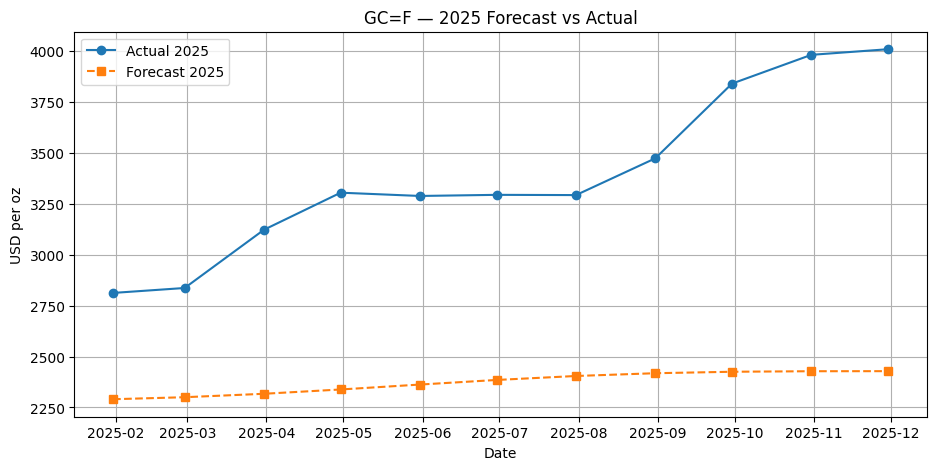

In [ ]:
plt.figure(figsize=(11,5))
plt.plot(valid["Date"], valid["Price"], "o-", label="Actual 2025")
plt.plot(valid["Date"], valid["Forecast"], "s--", label="Forecast 2025")
plt.title("GC=F — 2025 Forecast vs Actual")
plt.xlabel("Date"); plt.ylabel("USD per oz")
plt.grid(True); plt.legend(); plt.show()


Option A — Improve our current model (add harmonics + polynomial trend)


In [ ]:
t_tr = train["t_days"].values
y_tr = train["Price"].values


In [ ]:
# Hyperparameters you can tweak:
degree_trend = 2   # 1=linear, 2=quadratic, 3=cubic (start with 2)
K = 3          # number of harmonics (1..3 is usually enough)

omega = 2*np.pi/365.0

def build_features(t_days, degree=2, K=3, omega=2*np.pi/365.0):
    """
    Build a simple feature matrix:
    [1, t, t^2, sin(ωt), cos(ωt), sin(2ωt), cos(2ωt), ... up to K]
    """
    t = np.asarray(t_days).reshape(-1, 1)
    feats = [np.ones_like(t)]  # intercept

    # polynomial terms t, t^2, ...
    for d in range(1, degree+1):
        feats.append(t**d)

    # Fourier harmonics
    for k in range(1, K+1):
        feats.append(np.sin(k*omega*t))
        feats.append(np.cos(k*omega*t))

    X = np.hstack(feats)
    return X

# Build train design matrix
X_tr = build_features(t_tr, degree=degree_trend, K=K, omega=omega)

# Closed-form least squares for all coefficients at once
theta, *_ = np.linalg.lstsq(X_tr, y_tr, rcond=None)

print("Num features:", X_tr.shape[1])
print("Coefficients learned (theta) length:", len(theta))


Num features: 9
Coefficients learned (theta) length: 9


In [ ]:
def predict_gold_optionA(ts):
    """
    Option A model (poly trend + K harmonics).
    Input: datetime-like (e.g., '2025-06-30')
    Output: float price estimate
    """
    ts = pd.to_datetime(ts)
    t_days = (ts - t0).days
    X = build_features([t_days], degree=degree_trend, K=K, omega=omega)
    yhat = float(X @ theta)
    return yhat

# Quick smoke tests
print("Predict 2024-12-31 →", predict_gold_optionA("2024-12-31"))
print("Predict 2025-06-30 →", predict_gold_optionA("2025-06-30"))


Predict 2024-12-31 → 2572.1471338035662
Predict 2025-06-30 → 2816.1666041562685


/tmp/ipython-input-2097396801.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(X @ theta)


Option A — Train MAE (2020–2024): 95.58 USD


/tmp/ipython-input-2097396801.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(X @ theta)


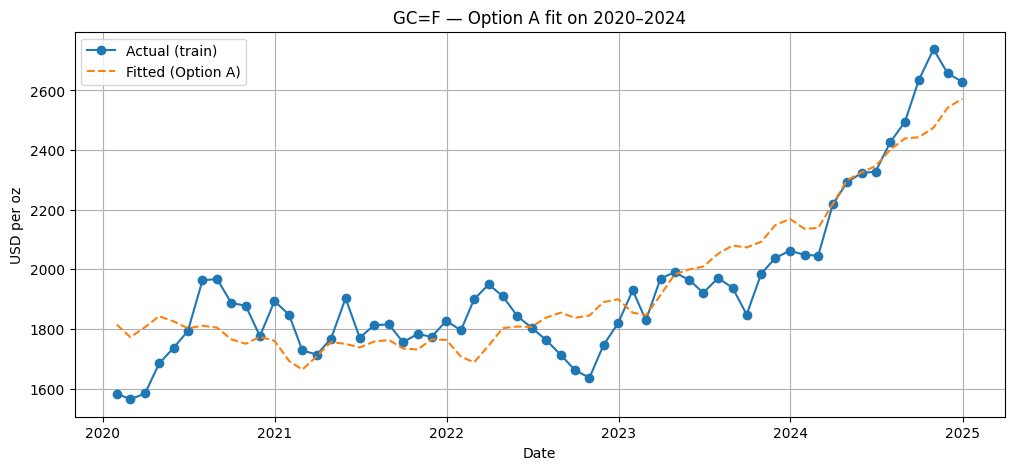

In [ ]:
train["Forecast_A"] = [predict_gold_optionA(d) for d in train["Date"]]
mae_train_A = np.mean(np.abs(train["Price"] - train["Forecast_A"]))
print(f"Option A — Train MAE (2020–2024): {mae_train_A:.2f} USD")

plt.figure(figsize=(12,5))
plt.plot(train["Date"], train["Price"], "o-", label="Actual (train)")
plt.plot(train["Date"], train["Forecast_A"], "--", label="Fitted (Option A)")
plt.title("GC=F — Option A fit on 2020–2024")
plt.xlabel("Date"); plt.ylabel("USD per oz")
plt.grid(True); plt.legend(); plt.show()


In [ ]:
test = test.copy()
test["Forecast_A"] = [predict_gold_optionA(d) for d in test["Date"]]
test["AbsErr"] = (test["Price"] - test["Forecast_A"]).abs()
test["APE"]    = test["AbsErr"] / test["Price"] * 100.0

mae_2025_A  = test["AbsErr"].mean()
mape_2025_A = test["APE"].mean()
print(f"Option A — 2025 MAE:  {mae_2025_A:.2f} USD")
print(f"Option A — 2025 MAPE: {mape_2025_A:.2f}%")

test[["Date","Price","Forecast_A","AbsErr","APE"]]


Option A — 2025 MAE:  575.31 USD
Option A — 2025 MAPE: 16.41%


/tmp/ipython-input-2097396801.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(X @ theta)


,Date,Price,Forecast_A,AbsErr,APE
60,2025-01-31,2812.500000,2549.506457,262.993543,9.350882
61,2025-02-28,2836.800049,2563.685458,273.114591,9.627559
62,2025-03-31,3122.800049,2655.819007,466.981042,14.953921
63,2025-04-30,3305.000000,2745.777460,559.222540,16.920500
64,2025-05-31,3288.899902,2783.568024,505.331879,15.364769
65,2025-06-30,3294.399902,2816.166604,478.233298,14.516553
66,2025-07-31,3293.199951,2882.008969,411.190983,12.486062
67,2025-08-31,3473.699951,2931.142508,542.557443,15.619007
68,2025-09-30,3840.800049,2946.386511,894.413537,23.287167
69,2025-10-31,3982.199951,2989.830190,992.369762,24.920139


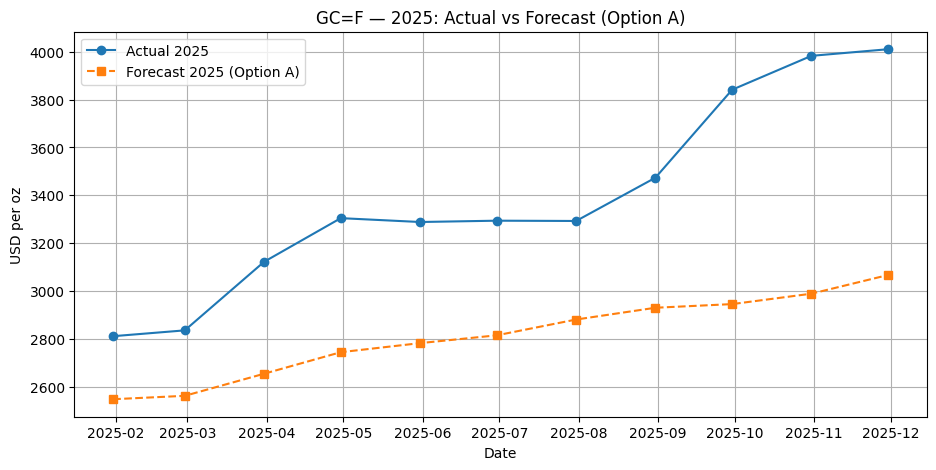

In [ ]:
plt.figure(figsize=(11,5))
plt.plot(test["Date"], test["Price"], "o-", label="Actual 2025")
plt.plot(test["Date"], test["Forecast_A"], "s--", label="Forecast 2025 (Option A)")
plt.title("GC=F — 2025: Actual vs Forecast (Option A)")
plt.xlabel("Date"); plt.ylabel("USD per oz")
plt.grid(True); plt.legend(); plt.show()


Option B: Tree models (Random Forest / XGBoost) with lagged features & rolling stats

In [ ]:
def add_time_features(df_in, t0):
    df = df_in.copy()
    df["t_days"]  = (df["Date"] - t0).dt.days.astype(float)
    df["t_days2"] = df["t_days"]**2

    # Cyclical month
    df["month"] = df["Date"].dt.month
    df["month_sin"] = np.sin(2*np.pi*df["month"]/12.0)
    df["month_cos"] = np.cos(2*np.pi*df["month"]/12.0)

    # Fourier harmonics on time
    omega = 2*np.pi/365.0
    for k in [1, 2, 3]:
        df[f"sin_{k}"] = np.sin(k*omega*df["t_days"])
        df[f"cos_{k}"] = np.cos(k*omega*df["t_days"])
    return df

def add_lag_rolling(df_in, price_col="Price"):
    df = df_in.copy()
    # Lagged prices
    for L in [1, 3, 6]:
        df[f"lag_{L}"] = df[price_col].shift(L)

    # Rolling means/stds of PRICE (use past only)
    df["roll3_mean"] = df[price_col].shift(1).rolling(3).mean()
    df["roll6_mean"] = df[price_col].shift(1).rolling(6).mean()
    df["roll3_std"]  = df[price_col].shift(1).rolling(3).std()
    df["roll6_std"]  = df[price_col].shift(1).rolling(6).std()
    return df

def add_return_features(df_in, price_col="Price"):
    df = df_in.copy()
    # Simple returns
    df["ret_1"] = df[price_col].pct_change(1)
    df["ret_3"] = df[price_col].pct_change(3)
    df["ret_6"] = df[price_col].pct_change(6)

    # Rate of change (same as multi-period return)
    df["roc_3"]  = df[price_col].pct_change(3)
    df["roc_6"]  = df[price_col].pct_change(6)
    df["roc_12"] = df[price_col].pct_change(12)

    # Volatility (rolling std of daily-ish return; on monthly we approximate with month pct changes)
    df["vol_3"] = df[price_col].pct_change().rolling(3).std()
    df["vol_6"] = df[price_col].pct_change().rolling(6).std()

    # RSI(14) on monthly series (approximate)
    delta = df[price_col].diff()
    gain = delta.where(delta > 0, 0).rolling(14).mean()
    loss = -delta.where(delta < 0, 0).rolling(14).mean()
    rs = gain / loss
    df["RSI"] = 100 - (100 / (1 + rs))
    return df

# Build features on the full monthly frame first (consistent lags/rolls)
feat_all = add_time_features(monthly, t0)
feat_all = add_lag_rolling(feat_all, "Price")
feat_all = add_return_features(feat_all, "Price")

# Split again (now with features)
feat_train = feat_all[(feat_all["Date"] >= "2020-01-01") & (feat_all["Date"] <= "2024-12-31")].copy()
feat_test  = feat_all[(feat_all["Date"] >= "2025-01-01") & (feat_all["Date"] <= "2025-12-31")].copy()

# Target = next-month return (ret_1 shifted -1)
feat_train["y_return_next"] = feat_train["ret_1"].shift(-1)

# Drop NAs from lags/rolls/target
feat_train = feat_train.dropna().reset_index(drop=True)
feat_test  = feat_test.dropna().reset_index(drop=True)

feature_cols = [
    "t_days", "t_days2",
    "month_sin", "month_cos",
    "sin_1", "cos_1", "sin_2", "cos_2", "sin_3", "cos_3",
    "lag_1", "lag_3", "lag_6",
    "roll3_mean", "roll6_mean", "roll3_std", "roll6_std",
    "ret_1", "ret_3", "ret_6",
    "roc_3", "roc_6", "roc_12",
    "vol_3", "vol_6", "RSI"
]

X_tr = feat_train[feature_cols].values
y_tr = feat_train["y_return_next"].values

X_te = feat_test[feature_cols].values
# For evaluation, we’ll compare predicted NEXT return against actual NEXT return,
# but to plot prices we’ll generate recursive price paths below.
y_te_nextret = feat_test["ret_1"].shift(-1)  # not used directly; recursive forecast handles prices


In [ ]:
rf = RandomForestRegressor(
    n_estimators=1500,
    max_depth=10,
    min_samples_leaf=4,
    max_features=0.6,
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_tr, y_tr)

# In-sample return MAE (rough diagnostic)
pred_tr_ret = rf.predict(X_tr)
mae_tr_ret = mean_absolute_error(y_tr, pred_tr_ret)
print(f"RF — Train MAE on next-month return: {mae_tr_ret:.5f}")


RF — Train MAE on next-month return: 0.01840


In [ ]:
def recursive_monthly_forecast_returns(model, monthly_df, feature_cols, end_date, t0):
    """
    Forecast month-end PRICES forward using a model that predicts NEXT-MONTH RETURN.
    Recursively rolls forward, adding predicted prices for future months to compute lags/rolls.
    """
    df = monthly_df.copy().sort_values("Date").reset_index(drop=True)
    current_date = df["Date"].iloc[-1]  # last known month with a price

    results = []

    while current_date < pd.to_datetime(end_date):
        next_date = current_date + pd.offsets.MonthEnd(1)

        # Append a placeholder for next month
        tmp = pd.concat([df, pd.DataFrame({"Date":[next_date], "Price":[np.nan]})], ignore_index=True)

        # Recompute features (lags/rolls need full history)
        tmp_feat = add_time_features(tmp, t0)
        tmp_feat = add_lag_rolling(tmp_feat, "Price")
        tmp_feat = add_return_features(tmp_feat, "Price")

        # Build feature row for the month where we want NEXT return (i.e., the last known month)
        # We need features as of current_date to predict return for next_date
        row_curr = tmp_feat[tmp_feat["Date"] == current_date].iloc[0]
        X_row = row_curr[feature_cols].values.reshape(1, -1)

        # Explicitly cast X_row to float to avoid TypeError with np.isnan on object dtypes
        X_row = X_row.astype(float)

        # If early NA features exist, simple impute with training means
        if np.isnan(X_row).any():
            col_means = np.nanmean(X_tr, axis=0)
            inds = np.where(np.isnan(X_row))
            X_row[inds] = col_means[inds[1]]

        # Predict next-month return
        r_next = float(model.predict(X_row)[0])

        # Base is the last available actual/predicted price (at current_date)
        base_price = df.loc[df["Date"] == current_date, "Price"].values[0]
        if np.isnan(base_price):
            # if base is nan (shouldn't happen), fallback to last non-nan
            base_price = df["Price"].ffill().iloc[-1]

        next_price = base_price * (1.0 + r_next)

        results.append({"Date": next_date, "Forecast": next_price, "PredReturn": r_next})

        # Write the predicted price back for recursive lags
        df.loc[len(df)] = {"Date": next_date, "Price": next_price}

        current_date = next_date

    return pd.DataFrame(results)

# Use historical up to 2024-12 end as baseline
hist_upto_2024 = monthly[monthly["Date"] <= "2024-12-31"].copy()
rf_fore_2025 = recursive_monthly_forecast_returns(
    model=rf,
    monthly_df=hist_upto_2024,
    feature_cols=feature_cols,
    end_date="2025-12-31",
    t0=t0
)

# Join with actual 2025 prices to evaluate
eval_rf = pd.merge(
    monthly[monthly["Date"].between("2025-01-01","2025-12-31")][["Date","Price"]],
    rf_fore_2025, on="Date", how="inner"
)
eval_rf["AbsErr"] = (eval_rf["Price"] - eval_rf["Forecast"]).abs()
eval_rf["APE_%"] = eval_rf["AbsErr"] / eval_rf["Price"] * 100

mae_rf_2025  = eval_rf["AbsErr"].mean()
mape_rf_2025 = eval_rf["APE_%"].mean()
print(f"RF — 2025 MAE:  {mae_rf_2025:.2f} USD")
print(f"RF — 2025 MAPE: {mape_rf_2025:.2f}%")

eval_rf

/tmp/ipython-input-338380010.py:34: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df["ret_1"] = df[price_col].pct_change(1)
/tmp/ipython-input-338380010.py:35: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df["ret_3"] = df[price_col].pct_change(3)
/tmp/ipython-input-338380010.py:36: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df["ret_6"] = df[price_col].pct_change(6)
/tmp/ipython-input-338380010.py

RF — 2025 MAE:  427.59 USD
RF — 2025 MAPE: 12.04%


,Date,Price,Forecast,PredReturn,AbsErr,APE_%
0,2025-01-31,2812.500000,2672.258318,0.016377,140.241682,4.986371
1,2025-02-28,2836.800049,2732.045527,0.022373,104.754521,3.692700
2,2025-03-31,3122.800049,2827.271549,0.034855,295.528500,9.463574
3,2025-04-30,3305.000000,2873.246746,0.016261,431.753254,13.063639
4,2025-05-31,3288.899902,2889.980459,0.005824,398.919443,12.129267
5,2025-06-30,3294.399902,2940.041647,0.017322,354.358255,10.756383
6,2025-07-31,3293.199951,3005.145801,0.022144,288.054151,8.746938
7,2025-08-31,3473.699951,3055.189325,0.016653,418.510626,12.047979
8,2025-09-30,3840.800049,3119.884082,0.021175,720.915967,18.769943
9,2025-10-31,3982.199951,3195.329305,0.024182,786.870646,19.759697


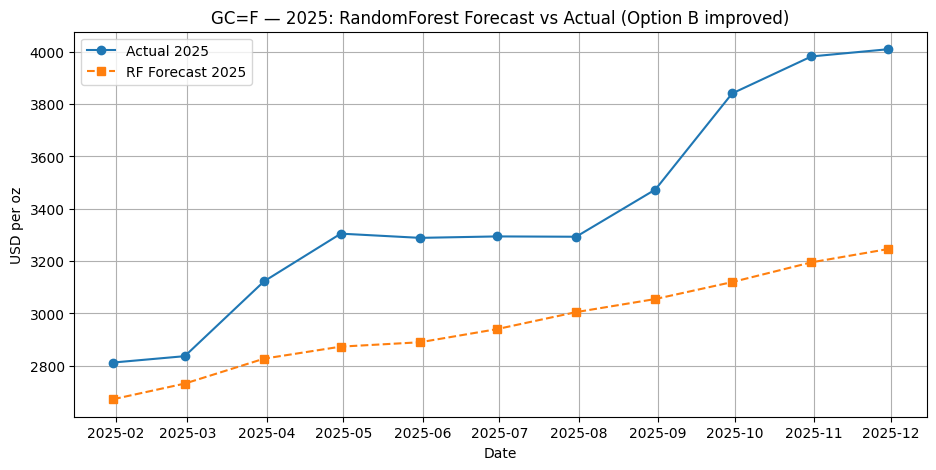

In [ ]:
plt.figure(figsize=(11,5))
plt.plot(eval_rf["Date"], eval_rf["Price"], "o-", label="Actual 2025")
plt.plot(eval_rf["Date"], eval_rf["Forecast"], "s--", label="RF Forecast 2025")
plt.title("GC=F — 2025: RandomForest Forecast vs Actual (Option B improved)")
plt.xlabel("Date"); plt.ylabel("USD per oz")
plt.grid(True); plt.legend(); plt.show()


XGBoost

In [ ]:
if XGB_OK:
    xgb = XGBRegressor(
        n_estimators=1200,
        max_depth=6,
        learning_rate=0.03,
        subsample=0.9,
        colsample_bytree=0.8,
        reg_lambda=5.0,
        random_state=42,
        n_jobs=-1,
        tree_method="hist"  # fast + robust
    )
    xgb.fit(X_tr, y_tr)

    # Recursive forecast for 2025 with XGB
    xgb_fore_2025 = recursive_monthly_forecast_returns(
        model=xgb,
        monthly_df=hist_upto_2024,
        feature_cols=feature_cols,
        end_date="2025-12-31",
        t0=t0
    )

    eval_xgb = pd.merge(
        monthly[monthly["Date"].between("2025-01-01","2025-12-31")][["Date","Price"]],
        xgb_fore_2025, on="Date", how="inner"
    )
    eval_xgb["AbsErr"] = (eval_xgb["Price"] - eval_xgb["Forecast"]).abs()
    eval_xgb["APE_%"] = eval_xgb["AbsErr"] / eval_xgb["Price"] * 100

    mae_xgb_2025  = eval_xgb["AbsErr"].mean()
    mape_xgb_2025 = eval_xgb["APE_%"].mean()
    print(f"XGB — 2025 MAE:  {mae_xgb_2025:.2f} USD")
    print(f"XGB — 2025 MAPE: {mape_xgb_2025:.2f}%")
else:
    print("Skipping XGBoost because it's not installed.")


/tmp/ipython-input-338380010.py:34: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df["ret_1"] = df[price_col].pct_change(1)
/tmp/ipython-input-338380010.py:35: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df["ret_3"] = df[price_col].pct_change(3)
/tmp/ipython-input-338380010.py:36: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df["ret_6"] = df[price_col].pct_change(6)
/tmp/ipython-input-338380010.py

XGB — 2025 MAE:  300.69 USD
XGB — 2025 MAPE: 8.49%


/tmp/ipython-input-338380010.py:34: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df["ret_1"] = df[price_col].pct_change(1)
/tmp/ipython-input-338380010.py:35: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df["ret_3"] = df[price_col].pct_change(3)
/tmp/ipython-input-338380010.py:36: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df["ret_6"] = df[price_col].pct_change(6)
/tmp/ipython-input-338380010.py

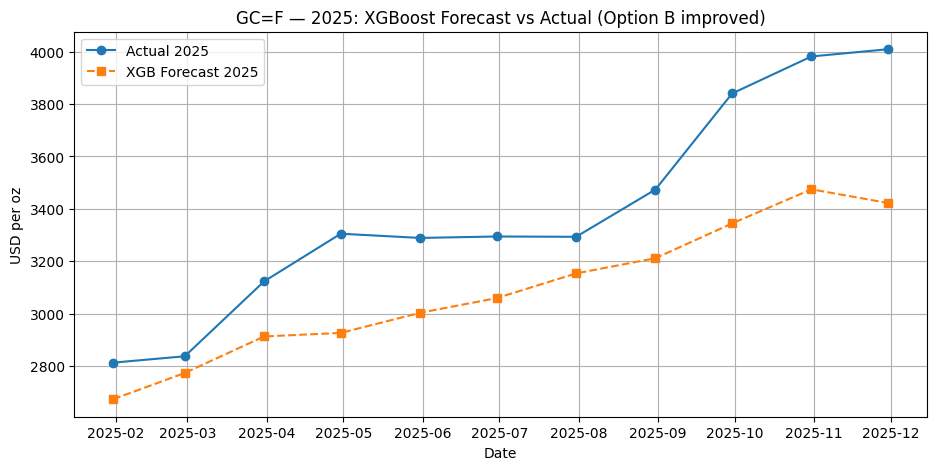

In [ ]:
if XGB_OK:
    plt.figure(figsize=(11,5))
    plt.plot(eval_xgb["Date"], eval_xgb["Price"], "o-", label="Actual 2025")
    plt.plot(eval_xgb["Date"], eval_xgb["Forecast"], "s--", label="XGB Forecast 2025")
    plt.title("GC=F — 2025: XGBoost Forecast vs Actual (Option B improved)")
    plt.xlabel("Date"); plt.ylabel("USD per oz")
    plt.grid(True); plt.legend(); plt.show()


In [ ]:
# Cache forecasts for 2025
rf_fore_cache = rf_fore_2025.set_index("Date") if 'rf_fore_2025' in globals() else None
xgb_fore_cache = xgb_fore_2025.set_index("Date") if XGB_OK and 'xgb_fore_2025' in globals() else None

def get_gold_price_estimate_optionB(date_like, model="rf"):
    """
    Returns a month-end estimate using Option B (improved).
    model: "rf" or "xgb"
    Logic:
      - If in historical data: return actual price.
      - If in 2025 and forecast exists: return cached forecast (RF/XGB).
      - If beyond 2025: extend recursively to that month with the chosen model.
    """
    ts = pd.to_datetime(date_like)
    me = ts + pd.offsets.MonthEnd(0)

    # Historical actual
    row = monthly[monthly["Date"] == me]
    if len(row) == 1 and not np.isnan(row["Price"].values[0]):
        return float(row["Price"].values[0])

    # Choose model + cache
    use_model = rf if model.lower() == "rf" else (xgb if (XGB_OK and 'xgb' in globals()) else rf)
    cache = rf_fore_cache if model.lower() == "rf" else (xgb_fore_cache if XGB_OK else rf_fore_cache)

    # Cached forecast for 2025
    if cache is not None and me in cache.index:
        return float(cache.loc[me, "Forecast"])

    # Else: extend recursively to requested month-end
    base_df = monthly[monthly["Date"] <= "2024-12-31"].copy()
    ext = recursive_monthly_forecast_returns(use_model, base_df, feature_cols, end_date=me, t0=t0)
    ext_idx = ext.set_index("Date")

    if me in ext_idx.index:
        return float(ext_idx.loc[me, "Forecast"])

    # Fallback: return last available forecast
    return float(ext_idx["Forecast"].iloc[-1])

# Examples
print("Option B (RF) — 2025-06-30:", get_gold_price_estimate_optionB("2025-06-30", model="rf"))
if XGB_OK:
    print("Option B (XGB) — 2025-06-30:", get_gold_price_estimate_optionB("2025-06-30", model="xgb"))


Option B (RF) — 2025-06-30: 3294.39990234375
Option B (XGB) — 2025-06-30: 3294.39990234375


SARIMA


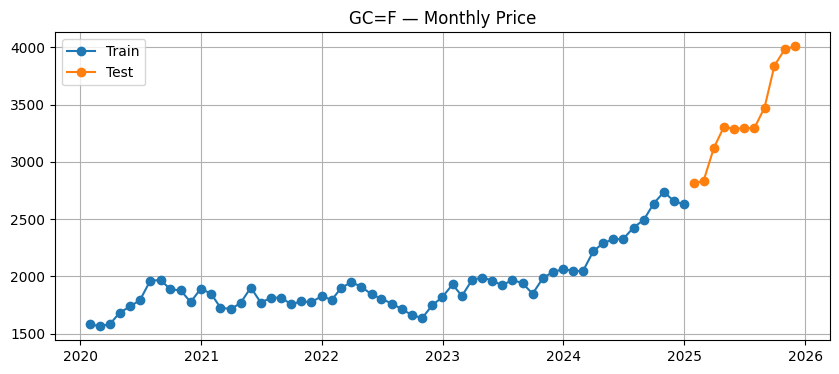

In [ ]:
train = train.copy()
test  = test.copy()

train["y"] = np.log(train["Price"])
test["y"]  = np.log(test["Price"])

plt.figure(figsize=(10,4))
plt.plot(train["Date"], train["Price"], marker='o', label="Train")
plt.plot(test["Date"], test["Price"], marker='o', label="Test")
plt.title("GC=F — Monthly Price")
plt.grid(True); plt.legend(); plt.show()


In [ ]:
def backtest_mae(endog, order, seasonal_order, val_horizon=12):
    """
    endog: pandas Series of log-prices indexed by integer 0..N-1
    order, seasonal_order: SARIMA orders
    val_horizon: number of final steps to treat as validation (e.g., 12 months)

    Returns: (mae, aic) where mae is validation MAE in log-space, aic from full-fit model
    """
    N = len(endog)
    split = N - val_horizon
    train_y = endog.iloc[:split]
    val_y   = endog.iloc[split:]

    # Fit on train_y
    try:
        model = SARIMAX(train_y, order=order, seasonal_order=seasonal_order, trend='c',
                        enforce_stationarity=False, enforce_invertibility=False)
        res = model.fit(disp=False)
    except Exception:
        return np.inf, np.inf  # invalid spec

    # Forecast validation horizon
    try:
        fc = res.get_forecast(steps=val_horizon)
        pred_mean = fc.predicted_mean
    except Exception:
        return np.inf, res.aic if hasattr(res, "aic") else np.inf

    mae = mean_absolute_error(val_y, pred_mean)
    # AIC from re-fit on full sample (optional but useful)
    try:
        full_res = SARIMAX(endog, order=order, seasonal_order=seasonal_order, trend='c',
                           enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
        aic = full_res.aic
    except Exception:
        aic = res.aic if hasattr(res, "aic") else np.inf

    return mae, aic


In [ ]:
y_series = train["y"].reset_index(drop=True)  # log-prices

pdq_list = [
    (0,1,1), (1,1,1), (2,1,1),
    (1,0,1), (2,0,1), (0,1,2)
]
seasonal_list = [
    (0,1,1,12), (1,1,1,12),
    (1,0,1,12), (0,1,2,12)
]

results = []
for order in pdq_list:
    for seas in seasonal_list:
        mae, aic = backtest_mae(y_series, order, seas, val_horizon=12)
        results.append((order, seas, mae, aic))

# Sort by val MAE, then AIC
results_sorted = sorted(results, key=lambda x: (x[2], x[3]))
best_order, best_seasonal, best_mae, best_aic = results_sorted[0]

print("Top candidates (first 5):")
for r in results_sorted[:5]:
    print(f"order={r[0]}, seasonal={r[1]}  |  val_MAE={r[2]:.5f}, AIC={r[3]:.1f}")

print("\nSelected BEST:")
print("order =", best_order, "seasonal =", best_seasonal, f"| val_MAE={best_mae:.5f}, AIC={best_aic:.1f}")


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood

Top candidates (first 5):
order=(1, 1, 1), seasonal=(0, 1, 2, 12)  |  val_MAE=0.04982, AIC=-68.0
order=(2, 1, 1), seasonal=(0, 1, 2, 12)  |  val_MAE=0.05009, AIC=-70.7
order=(1, 0, 1), seasonal=(0, 1, 2, 12)  |  val_MAE=0.05181, AIC=-74.4
order=(0, 1, 1), seasonal=(0, 1, 2, 12)  |  val_MAE=0.05452, AIC=-72.4
order=(0, 1, 2), seasonal=(0, 1, 2, 12)  |  val_MAE=0.06336, AIC=-69.7

Selected BEST:
order = (1, 1, 1) seasonal = (0, 1, 2, 12) | val_MAE=0.04982, AIC=-68.0


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
final_model = SARIMAX(
    y_series, order=best_order, seasonal_order=best_seasonal, trend='c',
    enforce_stationarity=False, enforce_invertibility=False
).fit(disp=False)

steps = len(test)  # forecast one year (12 months)
fc = final_model.get_forecast(steps=steps)
log_pred_2025 = fc.predicted_mean
log_ci_2025 = fc.conf_int(alpha=0.2)  # 80% bands in log-space for a tighter band

# Back-transform
pred_2025 = np.exp(log_pred_2025.values)
lower_2025 = np.exp(log_ci_2025.iloc[:, 0].values)
upper_2025 = np.exp(log_ci_2025.iloc[:, 1].values)

# Pack into DataFrame aligned to test dates
sarima_2025 = test[["Date","Price"]].copy().reset_index(drop=True)
sarima_2025["Forecast"] = pred_2025
sarima_2025["Lower80"]  = lower_2025
sarima_2025["Upper80"]  = upper_2025

sarima_2025


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,Date,Price,Forecast,Lower80,Upper80
0,2025-01-31,2812.500000,2678.989034,2559.786018,2803.743043
1,2025-02-28,2836.800049,2687.157664,2516.847281,2868.992635
2,2025-03-31,3122.800049,2898.431799,2672.419648,3143.558274
3,2025-04-30,3305.000000,2993.164708,2723.215293,3289.873918
4,2025-05-31,3288.899902,3048.648374,2741.274011,3390.488099
5,2025-06-30,3294.399902,3039.970228,2704.596173,3416.931177
6,2025-07-31,3293.199951,3158.146644,2782.471439,3584.543613
7,2025-08-31,3473.699951,3212.375670,2804.720490,3679.281940
8,2025-09-30,3840.800049,3272.627245,2833.148980,3780.277409
9,2025-10-31,3982.199951,3435.851512,2950.675975,4000.803786


SARIMA — 2025 MAE:  304.60 USD
SARIMA — 2025 MAPE: 8.63%


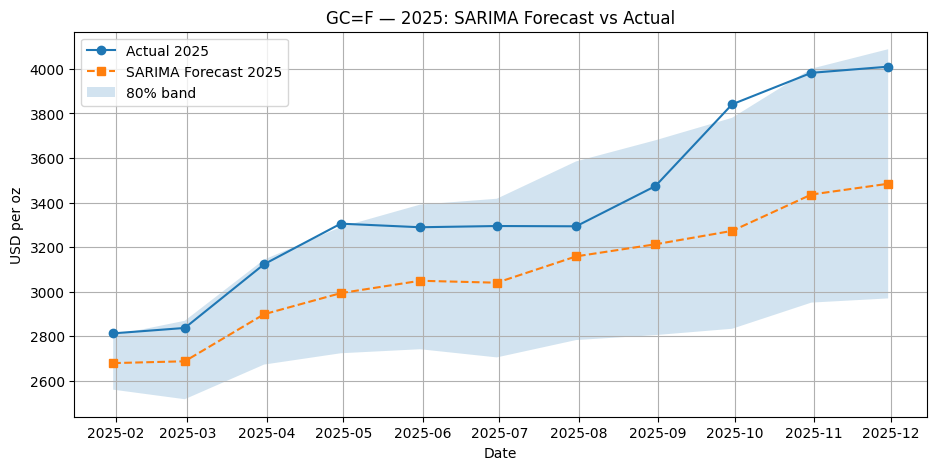

,Date,Price,Forecast,Lower80,Upper80,AbsErr,APE_%
0,2025-01-31,2812.500000,2678.989034,2559.786018,2803.743043,133.510966,4.747057
1,2025-02-28,2836.800049,2687.157664,2516.847281,2868.992635,149.642385,5.275042
2,2025-03-31,3122.800049,2898.431799,2672.419648,3143.558274,224.368249,7.184842
3,2025-04-30,3305.000000,2993.164708,2723.215293,3289.873918,311.835292,9.435258
4,2025-05-31,3288.899902,3048.648374,2741.274011,3390.488099,240.251528,7.304921
5,2025-06-30,3294.399902,3039.970228,2704.596173,3416.931177,254.429675,7.723096
6,2025-07-31,3293.199951,3158.146644,2782.471439,3584.543613,135.053307,4.100975
7,2025-08-31,3473.699951,3212.375670,2804.720490,3679.281940,261.324281,7.522938
8,2025-09-30,3840.800049,3272.627245,2833.148980,3780.277409,568.172804,14.793085
9,2025-10-31,3982.199951,3435.851512,2950.675975,4000.803786,546.348439,13.719764


In [ ]:
sarima_2025["AbsErr"] = (sarima_2025["Price"] - sarima_2025["Forecast"]).abs()
sarima_2025["APE_%"]  = sarima_2025["AbsErr"] / sarima_2025["Price"] * 100

mae_2025 = sarima_2025["AbsErr"].mean()
mape_2025 = sarima_2025["APE_%"].mean()
print(f"SARIMA — 2025 MAE:  {mae_2025:.2f} USD")
print(f"SARIMA — 2025 MAPE: {mape_2025:.2f}%")

plt.figure(figsize=(11,5))
plt.plot(sarima_2025["Date"], sarima_2025["Price"], "o-", label="Actual 2025")
plt.plot(sarima_2025["Date"], sarima_2025["Forecast"], "s--", label="SARIMA Forecast 2025")
plt.fill_between(sarima_2025["Date"], sarima_2025["Lower80"], sarima_2025["Upper80"], alpha=0.2, label="80% band")
plt.title("GC=F — 2025: SARIMA Forecast vs Actual")
plt.xlabel("Date"); plt.ylabel("USD per oz")
plt.grid(True); plt.legend(); plt.show()

sarima_2025


In [ ]:
# Cache the fitted model and the train end for step calculation
train_end_date = train["Date"].iloc[-1]

def get_gold_price_estimate_optionC(date_like):
    """
    Month-end estimate using SARIMA (Option C).
    - If date is in history: returns actual.
    - If date > train_end: forecasts steps ahead from the end of training sample.
    """
    ts = pd.to_datetime(date_like)
    me = ts + pd.offsets.MonthEnd(0)

    # Historical actual
    row = monthly[monthly["Date"] == me]
    if len(row) == 1 and not np.isnan(row["Price"].values[0]):
        return float(row["Price"].values[0])

    # Steps ahead from train_end_date
    if me <= monthly["Date"].iloc[-1]:
        # within our dataset but missing (unlikely) → use existing sarima_2025 if present
        if 'sarima_2025' in globals():
            row2 = sarima_2025[sarima_2025["Date"] == me]
            if len(row2) == 1:
                return float(row2["Forecast"].values[0])

    # Compute how many months ahead from train end
    # Count month steps between train_end_date and target month-end
    def month_diff(d1, d2):
        return (d2.year - d1.year)*12 + (d2.month - d1.month)

    steps_ahead = month_diff(pd.to_datetime(train_end_date), me)
    if steps_ahead <= 0:
        # fallback to last available price if something odd
        return float(monthly.loc[monthly["Date"] <= me, "Price"].iloc[-1])

    # Forecast steps_ahead from fitted SARIMA
    fc_any = final_model.get_forecast(steps=steps_ahead)
    log_pred = fc_any.predicted_mean.iloc[-1]
    return float(np.exp(log_pred))

# Examples:
print("Option C — 2025-06-30:", get_gold_price_estimate_optionC("2025-06-30"))
print("Option C — 2026-03-31:", get_gold_price_estimate_optionC("2026-03-31"))


Option C — 2025-06-30: 3294.39990234375
Option C — 2026-03-31: 4004.455849299034


option E

In [ ]:
# If needed:
# !pip install yfinance xgboost --quiet

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

try:
    from xgboost import XGBRegressor
    XGB_OK = True
except Exception as e:
    print("XGBoost not available; will fall back to RandomForest. (pip install xgboost)")
    XGB_OK = False

pd.set_option("display.width", 140)
pd.set_option("display.max_columns", 40)


In [ ]:
start = "2020-01-01"
end   = "2025-12-31"

tickers = {
    "GC=F": "Gold",
    "DX-Y.NYB": "DXY", # Corrected ticker for US Dollar Index
    "^TNX": "TNX",  # 10y yield in % points (e.g., 4.20, not 0.042)
    "^VIX": "VIX",
}

panels = {}
for tkr, name in tickers.items():
    df = yf.download(tkr, start=start, end=end, auto_adjust=True, progress=False)
    price_col = "Close" if "Adj Close" not in df.columns else "Adj Close"
    # Fix: Extract the specific MultiIndex column as a Series and then convert to a DataFrame with a single-level column name
    m = df[(price_col, tkr)].resample("M").last().to_frame(name=name)
    m.index.name = "Date"
    panels[name] = m

# Merge all to a single monthly frame
monthly = panels["Gold"].copy()
for name in ["DXY", "TNX", "VIX"]:
    monthly = monthly.join(panels[name], how="outer")

monthly = monthly.reset_index().dropna().reset_index(drop=True)
monthly.head(12)

/tmp/ipython-input-473384492.py:16: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  m = df[(price_col, tkr)].resample("M").last().to_frame(name=name)
/tmp/ipython-input-473384492.py:16: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  m = df[(price_col, tkr)].resample("M").last().to_frame(name=name)
/tmp/ipython-input-473384492.py:16: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  m = df[(price_col, tkr)].resample("M").last().to_frame(name=name)
/tmp/ipython-input-473384492.py:16: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  m = df[(price_col, tkr)].resample("M").last().to_frame(name=name)


,Date,Gold,DXY,TNX,VIX
0,2020-01-31,1582.900024,97.389999,1.520,18.840000
1,2020-02-29,1564.099976,98.129997,1.127,40.110001
2,2020-03-31,1583.400024,99.050003,0.698,53.540001
3,2020-04-30,1684.199951,99.019997,0.622,34.150002
4,2020-05-31,1736.900024,98.339996,0.648,27.510000
5,2020-06-30,1793.000000,97.389999,0.653,30.430000
6,2020-07-31,1962.800049,93.489998,0.536,24.459999
7,2020-08-31,1967.599976,92.139999,0.693,26.410000
8,2020-09-30,1887.500000,93.889999,0.677,26.370001
9,2020-10-31,1877.400024,94.040001,0.860,38.020000


In [ ]:
df = monthly.copy()

# Gold returns (%)
df["ret_g_1"]  = df["Gold"].pct_change(1)
df["ret_g_3"]  = df["Gold"].pct_change(3)
df["ret_g_6"]  = df["Gold"].pct_change(6)

# Macro changes and levels
df["ret_dxy_1"] = df["DXY"].pct_change(1)
df["ret_vix_1"] = df["VIX"].pct_change(1)
# TNX is in %, so change in basis points is helpful
df["d_tnx_bp_1"] = (df["TNX"].diff(1) * 100.0)  # 1%pt = 100bp

# Rolling stats (volatility & mean of gold returns)
df["rv_g_3"] = df["ret_g_1"].rolling(3).std()
df["rv_g_6"] = df["ret_g_1"].rolling(6).std()
df["ma_g_3"] = df["ret_g_1"].rolling(3).mean()
df["ma_g_6"] = df["ret_g_1"].rolling(6).mean()

# Calendar signals (weak for gold but harmless)
df["month"] = df["Date"].dt.month
df["m_sin"] = np.sin(2*np.pi*df["month"]/12.0)
df["m_cos"] = np.cos(2*np.pi*df["month"]/12.0)

# Target: next-month return of gold (predict ret_{t+1})
df["y_next_ret"] = df["ret_g_1"].shift(-1)

# Drop first rows with NaNs from rolling/lagging
df = df.dropna().reset_index(drop=True)
df.head()


,Date,Gold,DXY,TNX,VIX,ret_g_1,ret_g_3,ret_g_6,ret_dxy_1,ret_vix_1,d_tnx_bp_1,rv_g_3,rv_g_6,ma_g_3,ma_g_6,month,m_sin,m_cos,y_next_ret
0,2020-07-31,1962.800049,93.489998,0.536,24.459999,0.094702,0.165420,0.240003,-0.040045,-0.196188,-11.699998,0.036323,0.037662,0.052764,0.037069,7,-0.500000,-8.660254e-01,0.002445
1,2020-08-31,1967.599976,92.139999,0.693,26.410000,0.002445,0.132823,0.257976,-0.014440,0.079722,15.700001,0.047075,0.034237,0.043149,0.039456,8,-0.866025,-5.000000e-01,-0.040709
2,2020-09-30,1887.500000,93.889999,0.677,26.370001,-0.040709,0.052705,0.192055,0.018993,-0.001515,-1.600003,0.069173,0.047081,0.018813,0.030615,9,-1.000000,-1.836970e-16,-0.005351
3,2020-10-31,1877.400024,94.040001,0.860,38.020000,-0.005351,-0.043509,0.114713,0.001598,0.441790,18.300003,0.022998,0.045806,-0.014538,0.019113,10,-0.866025,5.000000e-01,-0.054171
4,2020-11-30,1775.699951,91.870003,0.844,20.570000,-0.054171,-0.097530,0.022339,-0.023075,-0.458969,-1.600003,0.025215,0.053844,-0.033410,0.004869,11,-0.500000,8.660254e-01,0.066115


In [ ]:
train = df[(df["Date"] >= "2020-01-01") & (df["Date"] <= "2024-12-31")].copy()
test  = df[(df["Date"] >= "2025-01-01") & (df["Date"] <= "2025-12-31")].copy()

feature_cols = [
    # Gold own-history
    "ret_g_1", "ret_g_3", "ret_g_6",
    "rv_g_3", "rv_g_6", "ma_g_3", "ma_g_6",
    # Macro levels/changes
    "DXY", "ret_dxy_1",
    "VIX", "ret_vix_1",
    "TNX", "d_tnx_bp_1",
    # Calendar
    "m_sin", "m_cos"
]

X_tr = train[feature_cols].values
y_tr = train["y_next_ret"].values

X_te = test[feature_cols].values
y_te = test["y_next_ret"].values  # for diagnostics on returns (not used for price path)
print("Train rows:", X_tr.shape[0], "Test rows:", X_te.shape[0], "Features:", len(feature_cols))


Train rows: 54 Test rows: 10 Features: 15


In [ ]:
tscv = TimeSeriesSplit(n_splits=4)

# Pipeline: standardize → ElasticNet
enet = Pipeline([
    ("scaler", StandardScaler()),
    ("model",  ElasticNet(max_iter=20000, random_state=42))
])

param_grid = [
    {"model__alpha": [0.0005, 0.001, 0.005, 0.01],
     "model__l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9]}
]

def grid_search_enet(X, y, tscv, param_grid):
    best = None
    for params in param_grid:
        for alpha in params["model__alpha"]:
            for l1_ratio in params["model__l1_ratio"]:
                enet_tmp = Pipeline([
                    ("scaler", StandardScaler()),
                    ("model",  ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=20000, random_state=42))
                ])
                maes = []
                for train_idx, val_idx in tscv.split(X):
                    enet_tmp.fit(X[train_idx], y[train_idx])
                    pred = enet_tmp.predict(X[val_idx])
                    maes.append(mean_absolute_error(y[val_idx], pred))
                mae = np.mean(maes)
                if (best is None) or (mae < best["mae"]):
                    best = {"alpha": alpha, "l1_ratio": l1_ratio, "mae": mae}
    return best

best_enet = grid_search_enet(X_tr, y_tr, tscv, param_grid)
best_enet


{'alpha': 0.01, 'l1_ratio': 0.9, 'mae': np.float64(0.036961860747575195)}

In [ ]:
enet_best = Pipeline([
    ("scaler", StandardScaler()),
    ("model",  ElasticNet(alpha=best_enet["alpha"],
                          l1_ratio=best_enet["l1_ratio"],
                          max_iter=20000, random_state=42))
])
enet_best.fit(X_tr, y_tr)

pred_tr_enet = enet_best.predict(X_tr)
print("ENet train MAE (next return):", mean_absolute_error(y_tr, pred_tr_enet))


ENet train MAE (next return): 0.032530910018506276


In [ ]:
if XGB_OK:
    xgb = XGBRegressor(
        n_estimators=1200,
        max_depth=6,
        learning_rate=0.035,
        subsample=0.9,
        colsample_bytree=0.8,
        reg_lambda=6.0,
        random_state=42,
        n_jobs=-1,
        tree_method="hist"
    )
    xgb.fit(X_tr, y_tr)
else:
    xgb = RandomForestRegressor(
        n_estimators=1200,
        max_depth=10,
        min_samples_leaf=4,
        max_features=0.6,
        bootstrap=True,
        random_state=42,
        n_jobs=-1
    )
    xgb.fit(X_tr, y_tr)

# Quick train diag
pred_tr_xgb = xgb.predict(X_tr)
print(("XGB" if XGB_OK else "RF") + " train MAE (next return):", mean_absolute_error(y_tr, pred_tr_xgb))


XGB train MAE (next return): 0.0003706190926525831


In [ ]:
def recursive_forecast_2025(enet_model, xgb_model, df_full, feature_cols):
    """
    Forecast 2025 month-end GOLD prices using:
    - ENet and XGB return predictions
    - Ensemble = average of ENet + XGB returns
    Returns a DataFrame with Forecast_ENet, Forecast_XGB, Forecast_Ens for 2025.
    """
    # Start from 2024-12 (last train month)
    hist = df_full.copy().sort_values("Date").reset_index(drop=True)

    # Seed price for 2024-12
    base_row = hist[hist["Date"] <= "2024-12-31"].iloc[-1]
    base_price = base_row["Gold"]

    # Rows of 2025 we will forecast
    rows_2025 = hist[(hist["Date"] >= "2025-01-01") & (hist["Date"] <= "2025-12-31")].copy()

    # We’ll carry a working copy to compute rolling features with predicted prices
    work = hist[hist["Date"] <= "2024-12-31"][["Date","Gold","DXY","TNX","VIX"]].copy()

    forecasts = []
    last_price = base_price

    for dt in rows_2025["Date"]:
        # Build one-row feature snapshot using info up to last known month
        tmp = work.copy()
        # Add a placeholder row for current month (so pct_change/rolling are aligned)
        tmp = pd.concat([tmp, pd.DataFrame({"Date":[dt], "Gold":[np.nan],
                                            "DXY":[hist.loc[hist['Date']==dt,'DXY'].values[0]],
                                            "TNX":[hist.loc[hist['Date']==dt,'TNX'].values[0]],
                                            "VIX":[hist.loc[hist['Date']==dt,'VIX'].values[0]]
                                           })], ignore_index=True)

        # Recreate features exactly as before
        tmp["ret_g_1"]  = tmp["Gold"].pct_change(1)
        tmp["ret_g_3"]  = tmp["Gold"].pct_change(3)
        tmp["ret_g_6"]  = tmp["Gold"].pct_change(6)
        tmp["ret_dxy_1"] = tmp["DXY"].pct_change(1)
        tmp["ret_vix_1"] = tmp["VIX"].pct_change(1)
        tmp["d_tnx_bp_1"] = (tmp["TNX"].diff(1) * 100.0)

        tmp["rv_g_3"] = tmp["ret_g_1"].rolling(3).std()
        tmp["rv_g_6"] = tmp["ret_g_1"].rolling(6).std()
        tmp["ma_g_3"] = tmp["ret_g_1"].rolling(3).mean()
        tmp["ma_g_6"] = tmp["ret_g_1"].rolling(6).mean()

        tmp["month"] = tmp["Date"].dt.month
        tmp["m_sin"] = np.sin(2*np.pi*tmp["month"]/12.0)
        tmp["m_cos"] = np.cos(2*np.pi*tmp["month"]/12.0)

        # Fill the last known gold (for computing ret features at dt)
        tmp.loc[tmp["Date"] == dt, "Gold"] = last_price  # use last realized/predicted price

        feat_row = tmp[tmp["Date"] == dt][feature_cols].iloc[0].values.reshape(1,-1)

        # Explicitly cast feat_row to float to avoid TypeError with np.isnan on object dtypes
        feat_row = feat_row.astype(float)

        # Simple imputation for early NAs in lags (rare in 2025)
        if np.isnan(feat_row).any():
            col_means = np.nanmean(X_tr, axis=0)
            idxs = np.where(np.isnan(feat_row))
            feat_row[idxs] = col_means[idxs[1]]

        # Predict next return for (dt -> next month)
        r_enet = float(enet_model.predict(feat_row)[0])
        r_xgb  = float(xgb_model.predict(feat_row)[0])
        r_ens  = 0.5*r_enet + 0.5*r_xgb

        # Convert to next month's price
        next_price_enet = last_price * (1 + r_enet)
        next_price_xgb  = last_price * (1 + r_xgb)
        next_price_ens  = last_price * (1 + r_ens)

        forecasts.append({"Date": dt,
                          "Forecast_ENet": next_price_enet,
                          "Forecast_XGB":  next_price_xgb,
                          "Forecast_Ens":  next_price_ens})

        # Update last_price using ensemble (can choose ENet/XGB if you prefer)
        last_price = next_price_ens

        # Append realized/predicted price row so that next loop has updated lags
        work.loc[len(work)] = {"Date": dt, "Gold": last_price,
                               "DXY": hist.loc[hist['Date']==dt,'DXY'].values[0],
                               "TNX": hist.loc[hist['Date']==dt,'TNX'].values[0],
                               "VIX": hist.loc[hist['Date']==dt,'VIX'].values[0]}

    return pd.DataFrame(forecasts)

fc_2025 = recursive_forecast_2025(enet_best, xgb, df, feature_cols)
fc_2025.head()

/tmp/ipython-input-649579572.py:35: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  tmp["ret_g_1"]  = tmp["Gold"].pct_change(1)
/tmp/ipython-input-649579572.py:36: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  tmp["ret_g_3"]  = tmp["Gold"].pct_change(3)
/tmp/ipython-input-649579572.py:37: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  tmp["ret_g_6"]  = tmp["Gold"].pct_change(6)
/tmp/ipython-input-649579

,Date,Forecast_ENet,Forecast_XGB,Forecast_Ens
0,2025-01-31,2658.430663,2731.739486,2695.085074
1,2025-02-28,2721.802964,2796.983344,2759.393154
2,2025-03-31,2785.411286,2933.362063,2859.386674
3,2025-04-30,2884.671178,2983.395731,2934.033454
4,2025-05-31,2964.662954,2966.307475,2965.485215


2025 MAE / MAPE (%)
ENet      → MAE:   369.67   MAPE:  10.66%
XGB       → MAE:   311.46   MAPE:   8.83%
Ensemble  → MAE:   340.56   MAPE:   9.74%


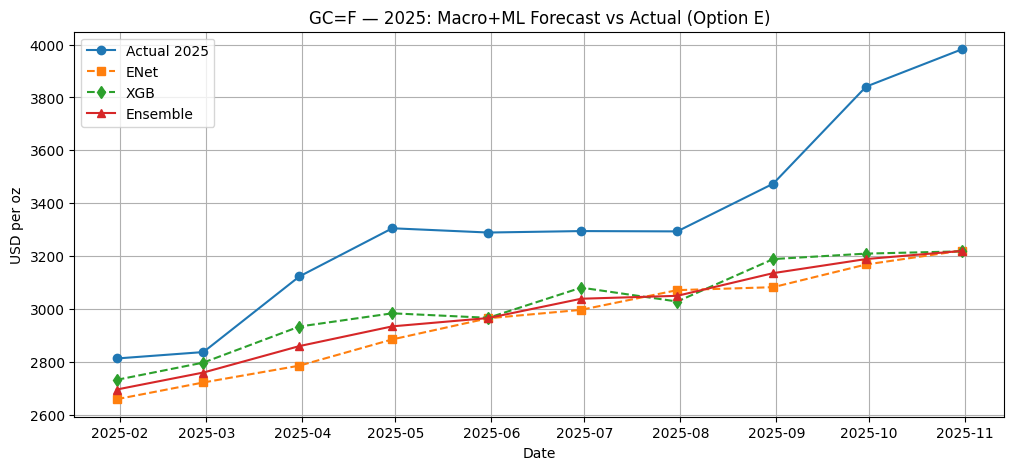

,Date,Gold,Forecast_ENet,Forecast_XGB,Forecast_Ens,AbsErr_Forecast_ENet,APE_Forecast_ENet,AbsErr_Forecast_XGB,APE_Forecast_XGB,AbsErr_Forecast_Ens,APE_Forecast_Ens
0,2025-01-31,2812.500000,2658.430663,2731.739486,2695.085074,154.069337,5.478021,80.760514,2.871485,117.414926,4.174753
1,2025-02-28,2836.800049,2721.802964,2796.983344,2759.393154,114.997084,4.053761,39.816705,1.403578,77.406895,2.728669
2,2025-03-31,3122.800049,2785.411286,2933.362063,2859.386674,337.388763,10.804046,189.437986,6.066286,263.413375,8.435166
3,2025-04-30,3305.000000,2884.671178,2983.395731,2934.033454,420.328822,12.717967,321.604269,9.730840,370.966546,11.224404
4,2025-05-31,3288.899902,2964.662954,2966.307475,2965.485215,324.236948,9.858523,322.592427,9.808521,323.414688,9.833522
5,2025-06-30,3294.399902,2996.535924,3080.448121,3038.492022,297.863978,9.041525,213.951781,6.494408,255.907880,7.767966
6,2025-07-31,3293.199951,3070.999565,3027.984802,3049.492184,222.200386,6.747249,265.215149,8.053418,243.707767,7.400333
7,2025-08-31,3473.699951,3082.211738,3188.505702,3135.358720,391.488214,11.270064,285.194249,8.210100,338.341232,9.740082
8,2025-09-30,3840.800049,3168.013171,3209.190864,3188.602017,672.786878,17.516842,631.609185,16.444730,652.198032,16.980786
9,2025-10-31,3982.199951,3220.837702,3217.812551,3219.325127,761.362249,19.119137,764.387400,19.195103,762.874825,19.157120


In [ ]:
actual_2025 = df[(df["Date"] >= "2025-01-01") & (df["Date"] <= "2025-12-31")][["Date","Gold"]].reset_index(drop=True)
eval_df = pd.merge(actual_2025, fc_2025, on="Date", how="inner")

for col in ["Forecast_ENet","Forecast_XGB","Forecast_Ens"]:
    eval_df[f"AbsErr_{col}"] = (eval_df["Gold"] - eval_df[col]).abs()
    eval_df[f"APE_{col}"]    = eval_df[f"AbsErr_{col}"] / eval_df["Gold"] * 100

metrics = {
    "ENet": (eval_df["AbsErr_Forecast_ENet"].mean(), eval_df["APE_Forecast_ENet"].mean()),
    "XGB" if XGB_OK else "RF": (eval_df["AbsErr_Forecast_XGB"].mean(), eval_df["APE_Forecast_XGB"].mean()),
    "Ensemble": (eval_df["AbsErr_Forecast_Ens"].mean(), eval_df["APE_Forecast_Ens"].mean())
}
print("2025 MAE / MAPE (%)")
for k,(mae,mape) in metrics.items():
    print(f"{k:9s} → MAE: {mae:8.2f}   MAPE: {mape:6.2f}%")

plt.figure(figsize=(12,5))
plt.plot(eval_df["Date"], eval_df["Gold"], "o-", label="Actual 2025")
plt.plot(eval_df["Date"], eval_df["Forecast_ENet"], "s--", label="ENet")
plt.plot(eval_df["Date"], eval_df["Forecast_XGB"], "d--", label=("XGB" if XGB_OK else "RF"))
plt.plot(eval_df["Date"], eval_df["Forecast_Ens"], "^-", label="Ensemble")
plt.title("GC=F — 2025: Macro+ML Forecast vs Actual (Option E)")
plt.xlabel("Date"); plt.ylabel("USD per oz")
plt.grid(True); plt.legend(); plt.show()

eval_df


In [ ]:
# Cache the 2025 forecast rows for quick access
cache_E = fc_2025.set_index("Date")

def get_gold_price_estimate_optionE(date_like, model="ens"):
    """
    Month-end price estimate using Option E (Macro + ML).
    model: 'enet', 'xgb' (or 'rf' if xgb not installed), or 'ens' (recommended).
    """
    ts = pd.to_datetime(date_like)
    me = ts + pd.offsets.MonthEnd(0)

    # Historical actual
    row = df[df["Date"] == me]
    if len(row) == 1 and not np.isnan(row["Gold"].values[0]):
        return float(row["Gold"].values[0])

    # 2025 cached forecasts
    if me in cache_E.index:
        if model.lower() == "enet":
            return float(cache_E.loc[me, "Forecast_ENet"])
        elif model.lower() in ["xgb","rf"]:
            return float(cache_E.loc[me, "Forecast_XGB"])
        else:
            return float(cache_E.loc[me, "Forecast_Ens"])

    # Beyond 2025: extend recursively up to 'me' using ensemble
    # (You can adapt the recursive function to accept end_date=me)
    ext = recursive_forecast_2025(enet_best, xgb, df, feature_cols)
    ext_idx = ext.set_index("Date")
    if me in ext_idx.index:
        if model.lower() == "enet":
            return float(ext_idx.loc[me, "Forecast_ENet"])
        elif model.lower() in ["xgb","rf"]:
            return float(ext_idx.loc[me, "Forecast_XGB"])
        else:
            return float(ext_idx.loc[me, "Forecast_Ens"])
    return float(ext_idx["Forecast_Ens"].iloc[-1])

# Examples:
print("Option E (ens) — 2025-06-30:", get_gold_price_estimate_optionE("2025-06-30", model="ens"))
print("Option E (enet) — 2025-12-31:", get_gold_price_estimate_optionE("2025-12-31", model="enet"))
print("Option E (xgb) — 2025-12-31:", get_gold_price_estimate_optionE("2025-12-31", model=("xgb" if XGB_OK else "rf")))


Option E (ens) — 2025-06-30: 3294.39990234375


/tmp/ipython-input-649579572.py:35: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  tmp["ret_g_1"]  = tmp["Gold"].pct_change(1)
/tmp/ipython-input-649579572.py:36: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  tmp["ret_g_3"]  = tmp["Gold"].pct_change(3)
/tmp/ipython-input-649579572.py:37: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  tmp["ret_g_6"]  = tmp["Gold"].pct_change(6)
/tmp/ipython-input-649579

Option E (enet) — 2025-12-31: 3219.3251266183647


/tmp/ipython-input-649579572.py:35: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  tmp["ret_g_1"]  = tmp["Gold"].pct_change(1)
/tmp/ipython-input-649579572.py:36: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  tmp["ret_g_3"]  = tmp["Gold"].pct_change(3)
/tmp/ipython-input-649579572.py:37: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  tmp["ret_g_6"]  = tmp["Gold"].pct_change(6)
/tmp/ipython-input-649579

Option E (xgb) — 2025-12-31: 3219.3251266183647
